In [272]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely import get_coordinates, set_coordinates
from typing import List

In [313]:
# shorthand for datetime column

date_col = 'Citation Issued DateTime'

## Correct Some Incorrect Geom Information

There are still rows that have incorrect information. This could be fixed by using a better geocoder than the US Census one.

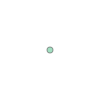

In [277]:
# 1ST -> 01ST, 2ND -> 02ND, etc., to be compatible
def inv_correct_numbered_streets(string):
    for i in range(1, 10):
        string = string.replace(f'{i}TH', f'0{i}TH')
    # 1st, 2nd and 3rd are special cases
    string = string.replace('1ST', '01ST')
    string = string.replace('2ND', '02ND')
    string = string.replace('3RD', '03RD')
    return string

def coord_string_to_point(coord_string):
    x, y = [float(string) for string in coord_string.split(',')]
    return Point(x, y)

coord_string_to_point("-122.46164710599999,37.77421091000008")

In [278]:
# read corrected addresses and transform into compatible address name format

geo = pd.read_csv('../data/chinook_ct_correct.csv', header=None)
geo = geo[geo[2] == 'Match']
geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
geo = geo[[1, 5]]
geo.columns = ['street', 'geom']
geo.street = geo.street.apply(inv_correct_numbered_streets)
geo.geom = geo.geom.apply(coord_string_to_point)
geo

,street,geom
0,785 04TH AVE,POINT (-122.46164710599999 37.77421091000008)
1,756 08TH AVE,POINT (-122.46593421399996 37.77422294300004)
2,277 05TH AVE,POINT (-122.46339279499995 37.783491569000034)
3,404 08TH AVE,POINT (-122.46639889099998 37.78064289800005)
4,398 05TH ST,POINT (-122.40188964199996 37.77906450900008)
...,...,...
2596,797 07TH AVE,POINT (-122.46482888199995 37.77366862200006)
2597,293 03RD AVE,POINT (-122.46122745499997 37.78333572200006)
2598,745 03RD ST,POINT (-122.39235078299998 37.77854485000006)
2599,485 07TH AVE,POINT (-122.46524249299995 37.77942227800003)


In [299]:
df = pd.read_csv("../data/data_2022_with_geom.csv")
df.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom
0,950226616,04/20/2022 12:10:00 PM,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
1,952126114,06/17/2022 04:12:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
2,950441903,04/23/2022 03:13:00 PM,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
3,948460144,02/22/2022 11:54:00 AM,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)
4,948169644,02/17/2022 01:39:00 PM,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42119800399996 37.800016984000024)


In [298]:
# TODO fix this

# df.loc[df['Citation Location'].isin(geo['street']), 'geom'] = geo['geom']

In [300]:
df.loc[df['Citation Location'].isin(geo['street']), 'geom']

1142       POINT (-122.37178541499998 37.824575492000065)
1143       POINT (-122.37178541499998 37.824575492000065)
1144       POINT (-122.37178541499998 37.824575492000065)
1145       POINT (-122.37178541499998 37.824575492000065)
1146       POINT (-122.37178541499998 37.824575492000065)
                                ...                      
1059296     POINT (-122.36677138399995 37.82210029500004)
1059499     POINT (-122.36664293399997 37.82467176700004)
1059555    POINT (-122.37244487399994 37.825514465000026)
1059576     POINT (-122.36698462299995 37.82516762100005)
1059811     POINT (-122.36863607199996 37.81810524400004)
Name: geom, Length: 9263, dtype: object

In [301]:
df['geom'] = df.geom.apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')
df.crs = 'EPSG:4326'

In [302]:
df[date_col] = pd.to_datetime(df[date_col])

In [303]:
df['citation_day'] = df[date_col].dt.day_name()

In [304]:
df['citation_hour'] = df[date_col].dt.hour

In [305]:
has_location_string = df[~df['Citation Location'].isnull()]

## Sunset EDA

In [309]:
# got from google maps

xmin = -122.51104739361378
xmax = -122.49545913522331

ymin = 37.756711165680095
ymax = 37.76421321760532

sunset_block = df.cx[xmin:xmax, ymin:ymax]
sunset_block.shape

(5998, 12)

In [327]:
def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

jan = filter_by_date_range(sunset_block, date_col, '2022-08-19', '2022-08-20').sort_values(date_col)
px.line(jan.set_index(date_col).resample('1H')['Violation'].count())

In [333]:
jan.sort_values(date_col).iloc[5:20]

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,citation_day,citation_hour
927045,954241702,2022-08-19 10:00:00,TRC7.2.22,STR CLEAN,1283 37TH AVE,CA,8NYW583,87.0,08/26/2022 12:00:00 AM,POINT (-122.49672 37.76305),Friday,10
858076,954241713,2022-08-19 10:01:00,TRC7.2.22,STR CLEAN,1325 37TH AVE,CA,8XVG021,87.0,09/21/2022 12:00:00 AM,POINT (-122.49670 37.76214),Friday,10
886849,954235321,2022-08-19 12:04:00,TRC7.2.22,STR CLEAN,1496 40TH AVE,CA,4VQT711,87.0,09/04/2022 12:00:00 AM,POINT (-122.49918 37.75900),Friday,12
424004,954228461,2022-08-19 12:05:00,TRC7.2.22,STR CLEAN,1223 39TH AVE,CA,7NCY224,87.0,10/08/2022 12:00:00 AM,POINT (-122.49898 37.76398),Friday,12
762721,954241724,2022-08-19 12:06:00,TRC7.2.22,STR CLEAN,1470 40TH AVE,CA,6UAL083,87.0,11/03/2022 12:00:00 AM,POINT (-122.49908 37.75942),Friday,12
938724,954228472,2022-08-19 12:07:00,TRC7.2.22,STR CLEAN,1235 39TH AVE,CA,6MNY669,87.0,10/25/2022 12:00:00 AM,POINT (-122.49897 37.76377),Friday,12
456453,954241746,2022-08-19 12:09:00,TRC7.2.22,STR CLEAN,1278 40TH AVE,CA,8VBR554,87.0,10/25/2022 12:00:00 AM,POINT (-122.49933 37.76300),Friday,12
927105,954228483,2022-08-19 12:10:00,TRC7.2.22,STR CLEAN,1491 39TH AVE,CA,7XNE850,87.0,11/21/2022 12:00:00 AM,POINT (-122.49859 37.75909),Friday,12
926291,954228494,2022-08-19 12:11:00,TRC7.2.22,STR CLEAN,1551 39TH AVE,CA,5LBP798,87.0,09/20/2022 12:00:00 AM,POINT (-122.49830 37.75794),Friday,12
926090,954241772,2022-08-19 12:16:00,TRC7.2.22,STR CLEAN,1514 40TH AVE,CA,7LGE515,87.0,08/30/2022 12:00:00 AM,POINT (-122.49929 37.75853),Friday,12


In [328]:
jan.to_csv('../data/jan_sunset_2.csv', index=False)

## Setup for Spatial Join

In [121]:
# need to write custom function for transforming geometry because
# geopandas to_crs doesn't work for some reason.

def transform_geometry(geom: gpd.GeoSeries, from_crs: int, to_crs: int):
    t = Transformer.from_crs(from_crs, to_crs, always_xy=True)
    new_geom = geom.copy()
    original_coords = geom.apply(get_coordinates)
    new_coords = original_coords.apply(lambda coords: np.array(t.transform(coords[:, 0], coords[:, 1])).T)
    temp_df = pd.DataFrame({'new_geom': new_geom, 'new_coords': new_coords})
    return temp_df.apply(lambda row: set_coordinates(row[0], row[1]), axis=1)

df['flat_geom'] = transform_geometry(df['geom'], 4326, 3857)

In [239]:
street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

street_df['flat_geom_street'] = transform_geometry(street_df['Line'], 4326, 3857)


unique_streets = street_df.drop_duplicates(subset='Line')
unique_streets = unique_streets[['Corridor', 'Limits', 'Line', 'flat_geom_street']]

# save copy of geom column because it will be destroyed by projection / join.
unique_streets['street_geom_3d'] = unique_streets['Line']

<AxesSubplot: >

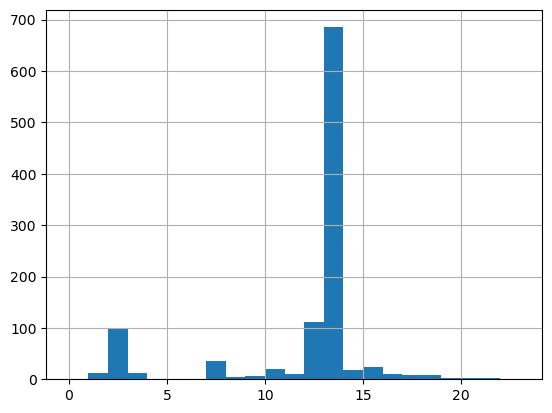

In [203]:
has_location_string[has_location_string['Citation Location'].str.contains('GREAT HWY')]['citation_hour'].hist(bins=range(24))

In [213]:
g

,Violation Description,Citation Location
113621,STR CLEAN,1546 GREAT HWY
113622,STR CLEAN,1546 GREAT HWY
113623,STR CLEAN,1546 GREAT HWY
115880,STR CLEAN,1420 GREAT HWY
115881,STR CLEAN,1420 GREAT HWY
...,...,...
1057951,STR CLEAN,1818 GREAT HWY
1057981,STR CLEAN,1668 GREAT HWY
1058675,STR CLEAN,1477 GREAT HWY
1058842,STR CLEAN,1887 GREAT HWY


<AxesSubplot: xlabel='Citation Issued DateTime'>

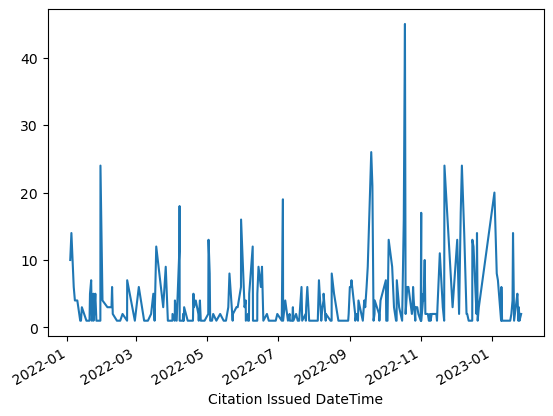

In [221]:
g = has_location_string[has_location_string['Citation Location'].str.contains('GREAT HWY')][['Violation Description', 'Citation Location', 'geom', 'Citation Issued DateTime']]
# g.explore()

In [280]:
g

,Violation Description,Citation Location,geom,Citation Issued DateTime
25980,PK PHB OTD,2800 GREAT HWY,POINT (-122.50662 37.73535),2022-01-29 12:39:00
25981,PK PHB OTD,2800 GREAT HWY,POINT (-122.50662 37.73535),2022-04-03 15:04:00
25982,PK PHB OTD,2800 GREAT HWY,POINT (-122.50662 37.73535),2022-03-26 16:33:00
25983,PK PHB OTD,2800 GREAT HWY,POINT (-122.50662 37.73535),2022-03-26 16:41:00
25984,PK PHB OTD,2800 GREAT HWY,POINT (-122.50662 37.73535),2022-03-26 16:35:00
...,...,...,...,...
1058175,PK PHB OTD,640 GREAT HWY,POINT (-122.51089 37.77505),2022-11-05 02:14:00
1058675,STR CLEAN,1477 GREAT HWY,POINT (-122.50927 37.75882),2022-10-18 13:15:00
1058842,STR CLEAN,1887 GREAT HWY,POINT (-122.50830 37.75123),2022-10-17 13:15:00
1058946,STR CLEAN,1345 GREAT HWY,POINT (-122.50959 37.76128),2022-11-01 13:10:00


In [297]:
grouper = g.groupby([pd.Grouper(key='Citation Issued DateTime', freq='1H'), 'Citation Location'])
px.line(grouper['Violation Description'].count().reset_index(), x='Citation Issued DateTime', y='Violation Description', line_group='Citation Location', color='Citation Location')

In [283]:
g.groupby('Citation Location').set_index('Citation Issued DateTime').resample('15T')

AttributeError: 'DataFrameGroupBy' object has no attribute 'set_index'

In [ ]:
px.line()

In [235]:
px.line(g.set_index('Citation Issued DateTime').resample('15T')['Violation Description'].count())

In [240]:
unique_streets['street_length'] = unique_streets.flat_geom_street.apply(lambda x: x.length)
unique_streets.street_length

0        117.140638
1        124.011653
2        106.616388
3        118.571571
4        138.279302
            ...    
37676    122.373596
37691    101.256499
37761    122.679953
37796    248.459393
37809    103.166613
Name: street_length, Length: 12242, dtype: float64

In [174]:
# exclude very long streets for now, for simplicity.

unique_streets[unique_streets.street_length > 1000]

,Corridor,Limits,Line,flat_geom_street,street_geom_3d,street_length
215,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51025 37...","LINESTRING (-13637788.813 4546140.481, -136377...","LINESTRING (-122.51034 37.76400, -122.51025 37...",4040.229167
377,Great Hwy,Lincoln Way - Sloat Blvd,"LINESTRING (-122.51034 37.76400, -122.51041 37...","LINESTRING (-13637788.813 4546140.481, -136377...","LINESTRING (-122.51034 37.76400, -122.51041 37...",4040.302247
607,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50666 37...","LINESTRING (-13637385.403 4542123.666, -136373...","LINESTRING (-122.50672 37.73547, -122.50666 37...",1621.518819
2474,Great Hwy,Sloat Blvd - Skyline Blvd,"LINESTRING (-122.50672 37.73547, -122.50682 37...","LINESTRING (-13637385.403 4542123.666, -136373...","LINESTRING (-122.50672 37.73547, -122.50682 37...",1640.270659
3218,John Muir Dr,Lake Merced Blvd - Skyline Blvd,"LINESTRING (-122.48572 37.70809, -122.48626 37...","LINESTRING (-13635048.410 4538269.796, -136351...","LINESTRING (-122.48572 37.70809, -122.48626 37...",2317.854843
14682,John F Shelley Dr,Cambridge St - Mansell St,"LINESTRING (-122.41648 37.72181, -122.41668 37...","LINESTRING (-13627340.710 4540200.996, -136273...","LINESTRING (-122.41648 37.72181, -122.41668 37...",1939.819746


In [242]:
normal_streets = unique_streets[unique_streets.street_length < 1000]
normal_streets.shape

(12236, 6)

In [144]:
# unique_streets = gpd.GeoDataFrame(pd.DataFrame(unique_streets), geometry='flat_geom_street')
# unique_streets.crs = 'EPSG:3857'

In [145]:
# hacky way to change geometry columns
# df = gpd.GeoDataFrame(pd.DataFrame(df), geometry='flat_geom')
# df.crs = 'EPSG:3857'

In [243]:
# there are some street segments that seem to be missing from the street cleaning dataset, so certain points get joined to multiple nearest street segments.
# TODO: figure out how to deal with the extra points. for now, let's just delete them all.

joined = gpd.sjoin_nearest(df, normal_streets, distance_col='dist', how='left')
joined.shape[0] - df.shape[0]

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning:

Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




4063

In [245]:
joined.head()

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,citation_day,citation_hour,index_right,Corridor,Limits,flat_geom_street,street_geom_3d,street_length,dist
0,950226616,2022-04-20 12:10:00,TRC7.2.22,STR CLEAN,1318 FILBERT ST,CA,V507699,84.0,05/01/2022 12:00:00 AM,POINT (-122.42120 37.80002),Wednesday,12,2854,Polk St,Union St - Filbert St,LINESTRING (-13627992.211045207 4551036.448611...,"LINESTRING (-122.42234 37.79876, -122.42253 37...",132.976735,0.001366
1,952126114,2022-06-17 16:12:00,TRC7.2.20,RES/OT,1318 FILBERT ST,CA,BV44D97,96.0,07/17/2022 12:00:00 AM,POINT (-122.42120 37.80002),Friday,16,2854,Polk St,Union St - Filbert St,LINESTRING (-13627992.211045207 4551036.448611...,"LINESTRING (-122.42234 37.79876, -122.42253 37...",132.976735,0.001366
2,950441903,2022-04-23 15:13:00,V5200,NO PLATES,1318 FILBERT ST,CA,V507699,121.0,05/18/2022 12:00:00 AM,POINT (-122.42120 37.80002),Saturday,15,2854,Polk St,Union St - Filbert St,LINESTRING (-13627992.211045207 4551036.448611...,"LINESTRING (-122.42234 37.79876, -122.42253 37...",132.976735,0.001366
3,948460144,2022-02-22 11:54:00,TRC7.2.20,RES/OT,1318 FILBERT ST,TX,HVT6737,96.0,05/23/2022 12:00:00 AM,POINT (-122.42120 37.80002),Tuesday,11,2854,Polk St,Union St - Filbert St,LINESTRING (-13627992.211045207 4551036.448611...,"LINESTRING (-122.42234 37.79876, -122.42253 37...",132.976735,0.001366
4,948169644,2022-02-17 13:39:00,TRC7.2.20,RES/OT,1318 FILBERT ST,OH,HQA6554,96.0,04/03/2022 12:00:00 AM,POINT (-122.42120 37.80002),Thursday,13,2854,Polk St,Union St - Filbert St,LINESTRING (-13627992.211045207 4551036.448611...,"LINESTRING (-122.42234 37.79876, -122.42253 37...",132.976735,0.001366


In [246]:
has_multiple_citations = joined['Citation Number'].value_counts()
joined = joined[joined['Citation Number'].isin(has_multiple_citations[has_multiple_citations == 1].index)]

In [247]:
joined['street_start_coord'] = joined['street_geom_3d'].apply(lambda line: line.coords[0])
joined['street_end_coord'] = joined['street_geom_3d'].apply(lambda line: line.coords[-1])

## Time Series Analysis

Let's see if there are any street sections that exhibit time series with some autocorrelation.

<AxesSubplot: >

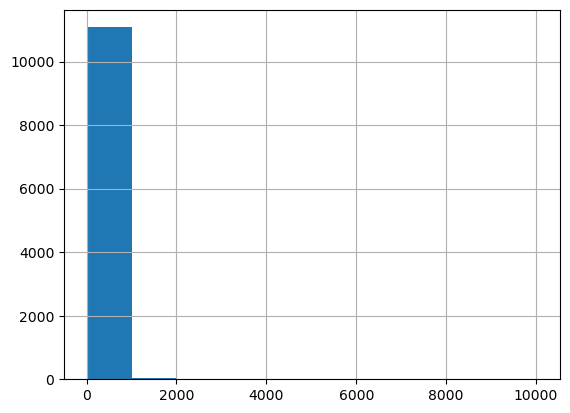

In [248]:
# there's one street section with an outlier of 10000 citations in a year

street_groups = joined.groupby(['street_start_coord', 'street_end_coord']).size().sort_values(ascending=False)
street_groups.hist()

In [249]:
street_groups.head()

street_start_coord                    street_end_coord                    
(-122.374467870815, 37.823860624294)  (-122.373719320651, 37.824614895609)    10034
(-122.381590796205, 37.712717648874)  (-122.382505694144, 37.709419118863)     9417
(-122.419506293804, 37.776368870039)  (-122.419693565872, 37.777299856161)     6882
(-122.386576970726, 37.771287570092)  (-122.387777955659, 37.771215259597)     5804
(-122.392499329227, 37.793768814045)  (-122.395405270407, 37.796682895937)     5538
dtype: int64

In [157]:
joined.Line

0          LINESTRING (-122.42234 37.79876, -122.42253 37...
1          LINESTRING (-122.42234 37.79876, -122.42253 37...
2          LINESTRING (-122.42234 37.79876, -122.42253 37...
3          LINESTRING (-122.42234 37.79876, -122.42253 37...
4          LINESTRING (-122.42234 37.79876, -122.42253 37...
                                 ...                        
1059933    LINESTRING (-122.47004 37.78644, -122.46991 37...
1059934    LINESTRING (-122.49472 37.73847, -122.49459 37...
1059935    LINESTRING (-122.48534 37.74263, -122.48520 37...
1059936    LINESTRING (-122.49531 37.77768, -122.49638 37...
1059937    LINESTRING (-122.39659 37.79459, -122.39780 37...
Name: Line, Length: 1055145, dtype: geometry

In [252]:
normal_streets[normal_streets.Corridor.str.contains('8th')]

,Corridor,Limits,Line,flat_geom_street,street_geom_3d,street_length
95,38th Ave,Santiago St - Taraval St,"LINESTRING (-122.49618 37.74402, -122.49605 37...",LINESTRING (-13636212.34525826 4543327.4230350...,"LINESTRING (-122.49618 37.74402, -122.49605 37...",263.458873
97,08th St,Hooper St - Wisconsin St,"LINESTRING (-122.40043 37.76730, -122.39968 37...",LINESTRING (-13625553.383215232 4546605.104139...,"LINESTRING (-122.40043 37.76730, -122.39968 37...",119.344926
176,08th Ave,Lincoln Way - Irving St,"LINESTRING (-122.46538 37.76597, -122.46524 37...",LINESTRING (-13632783.366510427 4546417.763210...,"LINESTRING (-122.46538 37.76597, -122.46524 37...",266.007533
272,08th Ave,Start: 01-99 Block - Lake St,"LINESTRING (-122.46685 37.78688, -122.46683 37...",LINESTRING (-13632947.763839083 4549363.231575...,"LINESTRING (-122.46685 37.78688, -122.46683 37...",44.536956
390,28th Ave,Moraga St - Noriega St,"LINESTRING (-122.48625 37.75568, -122.48612 37...",LINESTRING (-13635106.72230966 4544969.2076644...,"LINESTRING (-122.48625 37.75568, -122.48612 37...",263.271015
...,...,...,...,...,...,...
29017,28th Ave,Rivera St - Santiago St,"LINESTRING (-122.48560 37.74635, -122.48547 37...",LINESTRING (-13635034.323192948 4543655.858936...,"LINESTRING (-122.48560 37.74635, -122.48547 37...",262.437358
29372,18th St,Eureka St - Douglass St,"LINESTRING (-122.43827 37.76069, -122.43934 37...",LINESTRING (-13629765.355963986 4545674.604043...,"LINESTRING (-122.43827 37.76069, -122.43934 37...",119.628259
30441,18th St,York St - Bryant St,"LINESTRING (-122.40916 37.76182, -122.41012 37...",LINESTRING (-13626524.998367654 4545833.014169...,"LINESTRING (-122.40916 37.76182, -122.41012 37...",107.336723
30508,28th Ave,Clement St - Geary Blvd,"LINESTRING (-122.48809 37.78187, -122.48795 37...",LINESTRING (-13635311.252498949 4548657.656083...,"LINESTRING (-122.48809 37.78187, -122.48795 37...",271.904570


In [254]:
has_location_string_joined = joined[~joined['Citation Location'].isnull()]

has_location_string_joined[has_location_string_joined['Citation Location'].str.contains('09TH AVE')]

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,...,citation_hour,index_right,Corridor,Limits,flat_geom_street,street_geom_3d,street_length,dist,street_start_coord,street_end_coord
1124,945908132,2022-01-17 11:29:00,TRC7.2.23B,MTR OUT DT,390 09TH AVE,CA,7EYC601,86.0,02/22/2022 12:00:00 AM,POINT (-122.37162 37.82020),...,11,2897,Avenue B,lock Of 701 - 749,LINESTRING (-13622712.299824785 4554476.387103...,"LINESTRING (-122.37491 37.82317, -122.37504 37...",64.785820,0.004437,"(-122.374906700956, 37.82317492261)","(-122.375038495237, 37.823622689212)"
1125,947285345,2022-02-05 12:54:00,TRC7.2.23B,MTR OUT DT,390 09TH AVE,CA,8FHH630,86.0,03/06/2022 12:00:00 AM,POINT (-122.37162 37.82020),...,12,2897,Avenue B,lock Of 701 - 749,LINESTRING (-13622712.299824785 4554476.387103...,"LINESTRING (-122.37491 37.82317, -122.37504 37...",64.785820,0.004437,"(-122.374906700956, 37.82317492261)","(-122.375038495237, 37.823622689212)"
1126,952528846,2022-07-06 11:24:00,TRC7.2.23B,MTR OUT DT,390 09TH AVE,CA,7WCS506,86.0,07/13/2022 12:00:00 AM,POINT (-122.37162 37.82020),...,11,2897,Avenue B,lock Of 701 - 749,LINESTRING (-13622712.299824785 4554476.387103...,"LINESTRING (-122.37491 37.82317, -122.37504 37...",64.785820,0.004437,"(-122.374906700956, 37.82317492261)","(-122.375038495237, 37.823622689212)"
1127,953257686,2022-07-20 10:40:00,TRC7.2.23B,MTR OUT DT,390 09TH AVE,CA,8GHZ326,86.0,09/04/2022 12:00:00 AM,POINT (-122.37162 37.82020),...,10,2897,Avenue B,lock Of 701 - 749,LINESTRING (-13622712.299824785 4554476.387103...,"LINESTRING (-122.37491 37.82317, -122.37504 37...",64.785820,0.004437,"(-122.374906700956, 37.82317492261)","(-122.375038495237, 37.823622689212)"
1128,947569744,2022-01-25 09:10:00,TRC7.2.23B,MTR OUT DT,390 09TH AVE,CA,8VNR009,86.0,02/01/2022 12:00:00 AM,POINT (-122.37162 37.82020),...,9,2897,Avenue B,lock Of 701 - 749,LINESTRING (-13622712.299824785 4554476.387103...,"LINESTRING (-122.37491 37.82317, -122.37504 37...",64.785820,0.004437,"(-122.374906700956, 37.82317492261)","(-122.375038495237, 37.823622689212)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057864,956489575,2022-11-03 13:04:00,TRC7.2.20,RES/OT,559 09TH AVE,CA,8UXA035,99.0,01/11/2023 12:00:00 AM,POINT (-122.36689 37.82502),...,13,14196,Chinook Ct,lock Of 1438 - 1442,LINESTRING (-13622663.449476944 4554573.021660...,"LINESTRING (-122.37447 37.82386, -122.37364 37...",170.887445,0.006723,"(-122.374467870815, 37.823860624294)","(-122.373719320651, 37.824614895609)"
1058102,956572116,2022-10-27 13:01:00,TRC7.2.20,RES/OT,1587 09TH AVE,NY,KVL4195,99.0,11/26/2022 12:00:00 AM,POINT (-122.41964 37.77712),...,13,1226,Van Ness Ave,Fell St - Hayes St,LINESTRING (-13627677.103790212 4547882.225090...,"LINESTRING (-122.41951 37.77637, -122.41945 37...",137.688823,0.000059,"(-122.419506293804, 37.776368870039)","(-122.419693565872, 37.777299856161)"
1058249,956754805,2022-11-04 13:59:00,V22500E,DRIVEWAY,1746 09TH AVE,CA,8ZLX502,108.0,11/29/2022 12:00:00 AM,POINT (-122.41964 37.77712),...,13,1226,Van Ness Ave,Fell St - Hayes St,LINESTRING (-13627677.103790212 4547882.225090...,"LINESTRING (-122.41951 37.77637, -122.41945 37...",137.688823,0.000059,"(-122.419506293804, 37.776368870039)","(-122.419693565872, 37.777299856161)"
1058874,956381952,2022-10-20 13:11:00,TRC7.2.20,RES/OT,665 09TH AVE,PA,ZVH2245,99.0,01/10/2023 12:00:00 AM,POINT (-122.36736 37.82573),...,13,14196,Chinook Ct,lock Of 1438 - 1442,LINESTRING (-13622663.449476944 4554573.021660...,"LINESTRING (-122.37447 37.82386, -122.37364 37...",170.887445,0.006366,"(-122.374467870815, 37.823860624294)","(-122.373719320651, 37.824614895609)"


In [262]:
street_groups.head(n=10)

street_start_coord                    street_end_coord                    
(-122.374467870815, 37.823860624294)  (-122.373719320651, 37.824614895609)    10034
(-122.381590796205, 37.712717648874)  (-122.382505694144, 37.709419118863)     9417
(-122.419506293804, 37.776368870039)  (-122.419693565872, 37.777299856161)     6882
(-122.386576970726, 37.771287570092)  (-122.387777955659, 37.771215259597)     5804
(-122.392499329227, 37.793768814045)  (-122.395405270407, 37.796682895937)     5538
(-122.375593112581, 37.82452429883)   (-122.374377577827, 37.824935314043)     4011
(-122.374906700956, 37.82317492261)   (-122.375038495237, 37.823622689212)     3531
(-122.391634135111, 37.774327550675)  (-122.393653132349, 37.772732931119)     2935
(-122.388023343662, 37.78477361415)   (-122.3898463917, 37.783609176463)       2261
(-122.418593944952, 37.753836587811)  (-122.418445270656, 37.752239454508)     2240
dtype: int64

In [269]:
idx = 0
lst = joined[(joined.street_start_coord == street_groups.index[idx][0]) & (joined.street_end_coord == street_groups.index[idx][1])]['Citation Location'].unique()

In [270]:
from typing import List

# correct 01ST -> 1ST, 02ND -> 2ND, etc., so address can be read by geocoding APIs
def correct_numbered_streets(lst: List[str]):
    for i in range(1, 10):
        lst = [string.replace(f'0{i}TH', f'{i}TH') for string in lst]
    # 1st, 2nd and 3rd are special cases
    lst = [string.replace('01ST', '1ST') for string in lst]
    lst = [string.replace('02ND', '2ND') for string in lst]
    lst = [string.replace('03RD', '3RD') for string in lst]
    return lst

def convert_to_geocode_format(address_list, output_name='raw_address.csv'):
    address_list = correct_numbered_streets(address_list)
    pd.DataFrame({'street': address_list, 'city': 'SAN FRANCISCO', 'state': 'CA', 'zip': None}).head(n=10000).to_csv(output_name, header=False)

convert_to_geocode_format(lst, '../data/chinook_ct_wrong_addresses.csv')

In [271]:
geo = pd.read_csv('../data/chinook_ct_correct.csv', header=None)
geo = geo[geo[2] == 'Match']
geo[1] = geo[1].str.replace(', SAN FRANCISCO, CA,', '').apply(lambda x: x.strip())
geo = geo[[1, 5]]
geo.columns = ['street', 'latlong']
geo

,street,latlong
0,785 4TH AVE,"-122.46164710599999,37.77421091000008"
1,756 8TH AVE,"-122.46593421399996,37.77422294300004"
2,277 5TH AVE,"-122.46339279499995,37.783491569000034"
3,404 8TH AVE,"-122.46639889099998,37.78064289800005"
4,398 5TH ST,"-122.40188964199996,37.77906450900008"
...,...,...
2596,797 7TH AVE,"-122.46482888199995,37.77366862200006"
2597,293 3RD AVE,"-122.46122745499997,37.78333572200006"
2598,745 3RD ST,"-122.39235078299998,37.77854485000006"
2599,485 7TH AVE,"-122.46524249299995,37.77942227800003"


## Initialize Graph of Streets

Perhaps there's a less ad-hoc dataset for this.

In [39]:
import networkx as nx 

net = nx.MultiGraph()
key = 0

unique_streets["mm_len"] = unique_streets.geometry.length
fields = list(unique_streets.columns)

for row in unique_streets.itertuples():
    first = row.Line.coords[0]
    last = row.Line.coords[-1] 
    data = [r for r in row][1:]
    attributes = dict(zip(fields, data))
    net.add_edge(first, last, key=key, **attributes)
    key += 1
    net.add_edge(first, last, **attributes)  

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_86109/383711898.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  unique_streets["mm_len"] = unique_streets.geometry.length


## Try Analyzing Just One Day

In [46]:
one_day_df = joined[joined['Citation Issued DateTime'].dt.date == pd.to_datetime('2022-01-05')]

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_86109/3604098915.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  one_day_df = joined[joined['Citation Issued DateTime'].dt.date == pd.to_datetime('2022-01-05')]


In [53]:
one_day_df.sort_values('Citation Issued DateTime').iloc[10:20]

,Citation Number,Citation Issued DateTime,Violation,Violation Description,Citation Location,Vehicle Plate State,Vehicle Plate,Fine Amount,Date Added,geom,citation_day,index_right,Corridor,Limits,street_geom,dist
59917,946974840,2022-01-05 00:16:00,TRC7.2.22,STR CLEAN,355 BERRY ST,CA,8XGT397,85.0,01/12/2022 12:00:00 AM,POINT (-122.39711 37.77254),Wednesday,19461,Berry St,05th St - 06th St,"LINESTRING (-122.39558 37.77403, -122.39780 37...",0.000220
972757,946838642,2022-01-05 00:17:00,TRC7.2.22,STR CLEAN,64 13TH ST,CA,W046X0,85.0,10/08/2022 12:00:00 AM,POINT (-122.41465 37.76971),Wednesday,12593,Isis St,12th St - 13th St,"LINESTRING (-122.41434 37.77061, -122.41461 37...",0.000108
59918,946974851,2022-01-05 00:17:00,TRC7.2.22,STR CLEAN,355 BERRY ST,CA,8YVS424,85.0,12/22/2022 12:00:00 AM,POINT (-122.39711 37.77254),Wednesday,19461,Berry St,05th St - 06th St,"LINESTRING (-122.39558 37.77403, -122.39780 37...",0.000220
173027,946829763,2022-01-05 00:18:00,TRC7.2.35,PRK GRADE,213 BROADWAY,CA,8EIL774,60.0,02/05/2022 12:00:00 AM,POINT (-122.40123 37.79850),Wednesday,665,Broadway,Battery St - Sansome St,"LINESTRING (-122.40105 37.79858, -122.40223 37...",0.000053
748252,946838653,2022-01-05 00:18:00,TRC7.2.22,STR CLEAN,66 13TH ST,CA,8XBR415,85.0,02/01/2022 12:00:00 AM,POINT (-122.41468 37.76971),Wednesday,12593,Isis St,12th St - 13th St,"LINESTRING (-122.41434 37.77061, -122.41461 37...",0.000081
222008,946974862,2022-01-05 00:19:00,TRC7.2.22,STR CLEAN,327 BERRY ST,CA,7ZYD691,85.0,01/12/2022 12:00:00 AM,POINT (-122.39592 37.77366),Wednesday,19461,Berry St,05th St - 06th St,"LINESTRING (-122.39558 37.77403, -122.39780 37...",0.000079
340253,946058724,2022-01-05 00:19:00,TRC7.2.22,STR CLEAN,10 LANGTON ST,CA,6LAL945,85.0,05/29/2022 12:00:00 AM,POINT (-122.40975 37.77734),Wednesday,16986,Langton St,Howard St - Folsom St,"LINESTRING (-122.40992 37.77755, -122.40848 37...",0.000057
32180,946974873,2022-01-05 00:20:00,TRC7.2.22,STR CLEAN,255 BERRY ST,CA,8UNK800,85.0,01/12/2022 12:00:00 AM,POINT (-122.39474 37.77419),Wednesday,3751,Berry St,4th St - 05th St,"LINESTRING (-122.39336 37.77579, -122.39558 37...",0.000394
194086,946974884,2022-01-05 00:21:00,TRC7.2.22,STR CLEAN,261 BERRY ST,CA,8HCF887,85.0,06/12/2022 12:00:00 AM,POINT (-122.39465 37.77466),Wednesday,3751,Berry St,4th St - 05th St,"LINESTRING (-122.39336 37.77579, -122.39558 37...",0.000084
247231,946058746,2022-01-05 00:21:00,TRC7.2.22,STR CLEAN,90 LANGTON ST,CA,8YIV867,85.0,05/29/2022 12:00:00 AM,POINT (-122.40860 37.77640),Wednesday,16986,Langton St,Howard St - Folsom St,"LINESTRING (-122.40992 37.77755, -122.40848 37...",0.000070


In [57]:
street_df[~street_df.Limits.isin(joined.Limits.unique())]

,CNN,Corridor,Limits,CNNRightLeft,BlockSide,FullName,WeekDay,FromHour,ToHour,Week1,Week2,Week3,Week4,Week5,Holidays,BlockSweepID,Line
16,7746000,Kearny St,03rd St - Geary St,R,East,HOLIDAY,Holiday,2,6,1,1,1,1,1,1,1623897,"LINESTRING (-122.40343 37.78764, -122.40349 37..."
157,13202000,Ventura Ave,Castenada Ave - End: 89-99 Block,R,SouthEast,Tue 1st & 3rd,Tues,8,10,1,0,1,0,0,0,1640081,"LINESTRING (-122.46227 37.75097, -122.46220 37..."
233,104002,01st St,Transbay Hump - Minna St,L,NaN,Tuesday,Tues,0,2,1,1,1,1,1,0,1601978,"LINESTRING (-122.39727 37.78952, -122.39703 37..."
313,230201,03rd St,Ingerson Ave - Salinas Ave,R,NorthWest,Wednesday,Wed,2,6,1,1,1,1,1,0,1614470,"LINESTRING (-122.39627 37.72098, -122.39638 37..."
324,7709202,Junipero Serra Blvd,Stratford Dr - 19th Ave,R,West,Thu 2nd & 4th,Thu,7,8,0,1,0,1,0,0,1642221,"LINESTRING (-122.47260 37.71858, -122.47265 37..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37582,8675101,Mansell St,Brazil Ave - Mansell St,L,South,Monday,Mon,12,15,1,1,1,1,1,0,1640363,"LINESTRING (-122.42247 37.71789, -122.42249 37..."
37653,4501000,Crescent Ave,Putnam St - Alemany Blvd Off Ramp,L,NorthWest,Thu 2nd & 4th,Thu,8,10,0,1,0,1,0,0,1603375,"LINESTRING (-122.41117 37.73507, -122.41097 37..."
37756,2387000,Arballo Dr,Higuera Ave - Gonzalez Dr,R,West,Tue 2nd & 4th,Tues,9,11,0,1,0,1,0,0,1600756,"LINESTRING (-122.48316 37.71827, -122.48321 37..."
37766,4509000,Cresta Vista Dr,Globe Aly - Globe Aly,R,South,Tue 2nd & 4th,Tues,12,14,0,1,0,1,0,0,1630064,"LINESTRING (-122.45782 37.73552, -122.45759 37..."
